Part a

In [31]:
# 本cell主要进行数据读入与重整
# 导入必要的库
# This cell mainly focuses on data reading and restructuring.
# Import necessary libraries.
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import numpy as np

# 读取big8数据文件为data并转化日期格式以便于处理
# Read the big8 data file as data and convert the date format for easy processing
data = pd.read_csv(
    "./hw1 data/big8.txt",
    sep=" ",
    quotechar='"',
    parse_dates=["DATE"],
    date_format=lambda x: pd.to_datetime(x, format="%Y%m%d")
)

# 使用透视图重构表格，使相同日期的RETX数据在同一行
# Use a pivot table to restructure the table so that the RETX data for the same date is on the same row.
X_pivot = data.pivot(
    index="DATE",
    columns="TICKER",
    values="RETX"
).reset_index()
y_series = data[["DATE", "sprtrn"]].drop_duplicates().sort_values("DATE")
data = pd.merge(X_pivot, y_series, on="DATE", how="inner")

# 提取各个公司的RETX数据并使用scale函数标准化得到X，再提取sprtrn数据并标准化得到y
# 题目要求在整个big8数据集上计算回归模型，因此此处不进行训练集和测试集的划分
# Extract the RETX data of each company and normalize it using the scale function to get X. Then extract the sprtrn data and normalize it to get y.
# The question requires calculating the regression model on the entire big8 dataset, so there is no division into training and test sets here.
companies = ["AIG", "C", "COP", "F", "GE", "GM", "IBM", "XOM"]
X = scale(data[companies])
y = scale(data["sprtrn"])

In [32]:
def equation_show(alg, model):
    """用于展示回归模型形式、最佳超参数、相关系数和MSE的函数，在每个回归模型完成后运行"""
    """A function used to display the form of the regression model, the best hyperparameters, the correlation coefficient, and the MSE. Run it after each regression model is completed."""
    print(f'{alg}:\n')
    
    try:
        print('Optimal alpha:', model.alpha_)
    except:
        pass

    intercept = model.intercept_
    coefficients = model.coef_

    equation = f"sprtrn = {intercept:.10f}"
    for company, coef in zip(companies, coefficients):
        if coef != 0:  
            equation += f" + ({coef:.10f} × {company})"

    print("Regression Equation:")
    print(equation)

    r2 = model.score(X, y)
    print(f"R²: {r2:.10f}")

    y_hat = model.predict(X)
    mse = mean_squared_error(y, y_hat)
    print('MSE: {0}'.format(mse))

In [33]:
# (i).OLS
alg = 'OLS'

# 使用fit_intercept=True显式添加截距项，下同
# Explicitly add an intercept term using fit_intercept=True. The same applies below.
lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(X, y)

equation_show(alg, lm)

OLS:

Regression Equation:
sprtrn = 0.0000000000 + (0.1437725114 × AIG) + (0.3455577872 × C) + (0.1084268924 × COP) + (0.0967706836 × F) + (0.2515754961 × GE) + (0.0912072174 × GM) + (0.2307186749 × IBM) + (0.0293804692 × XOM)
R²: 0.8413398778
MSE: 0.15866012217651534


In [34]:
# (ii).Lasso
alg = 'Lasso'

# 由于样本量不大，故使用5折交叉验证得到最优超参数alpha
# Since the sample size is not large, 5 - fold cross - validation is used to obtain the optimal hyperparameter alpha.
alphas = 0.001 * np.arange(1, 101)
lasso_cv = linear_model.LassoCV(alphas=alphas, cv=5, random_state=0, fit_intercept=True).fit(X, y)

equation_show(alg, lasso_cv)

Lasso:

Optimal alpha: 0.016
Regression Equation:
sprtrn = 0.0000000000 + (0.1346729712 × AIG) + (0.3441598678 × C) + (0.0951364645 × COP) + (0.0904032741 × F) + (0.2506997143 × GE) + (0.0889133602 × GM) + (0.2223907480 × IBM) + (0.0325176034 × XOM)
R²: 0.8407235789
MSE: 0.15927642108871218


In [35]:
# (iii).Ridge
alg = 'Ridge'

# 使用对数空间上的5折交叉验证得到最佳超参数alpha
# Obtain the optimal hyperparameter alpha using 5 - fold cross - validation in the logarithmic space.
alphas = np.logspace(-2, 2, 100)
ridge_cv = linear_model.RidgeCV(alphas=alphas, cv=5, fit_intercept=True).fit(X, y)

equation_show(alg, ridge_cv)

Ridge:

Optimal alpha: 29.836472402833405
Regression Equation:
sprtrn = 0.0000000000 + (0.1440376875 × AIG) + (0.3074070323 × C) + (0.0886340842 × COP) + (0.0988367729 × F) + (0.2310303289 × GE) + (0.1030656457 × GM) + (0.2178852988 × IBM) + (0.0650733106 × XOM)
R²: 0.8392989637
MSE: 0.1607010362992561


Part b

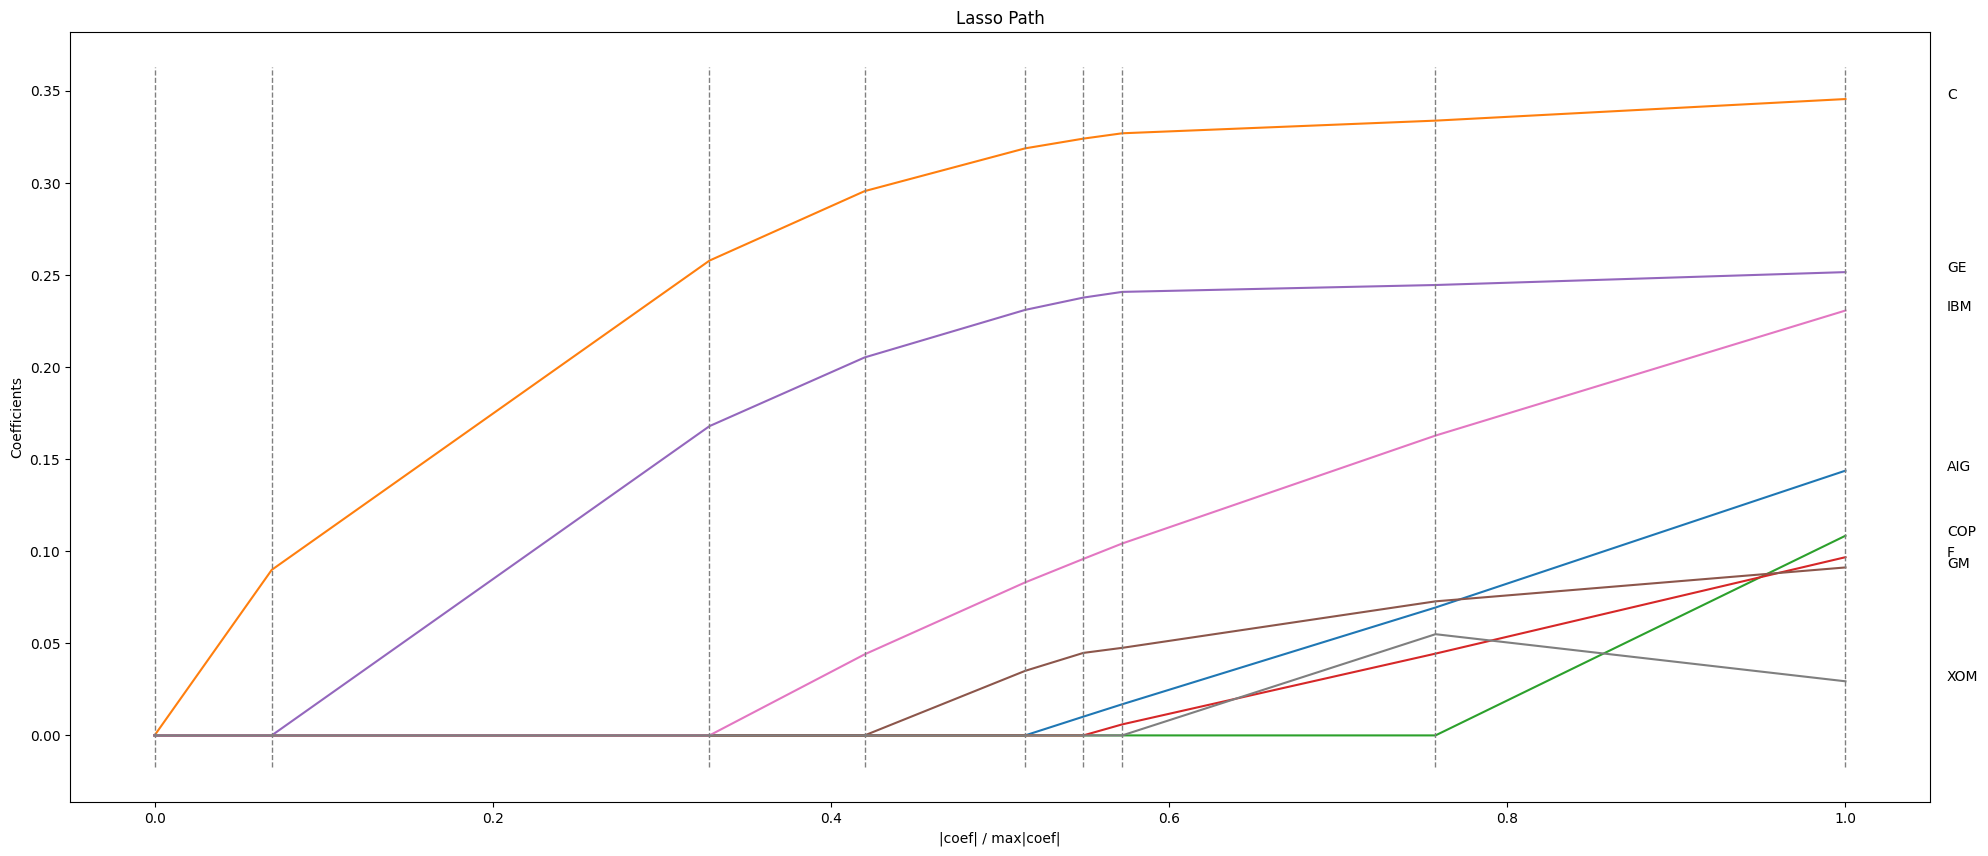

In [36]:
# 由于CV后optimal alpha下的各系数均非零，故本cell借用之前所给的代码绘制lasso的正则化路径图，以实现变量选择
# Since all coefficients under the optimal alpha after cross - validation (CV) are non - zero, this cell borrows the previously provided code to draw the regularization path plot of Lasso, in order to achieve variable selection.


# Def a function for visualization
def plot_path(coefs, varnames, method):
    # Calculate the L1-norm of the coefficients at each step
    t = np.sum(np.abs(coefs), axis=0)

    # Normalize the coefficients by dividing by their maximum L1-norm
    s = t / t[-1]

    # Plot coefficient paths over the normalized L1-norm
    plt.plot(s, coefs.T)

    # Add vertical dashed lines at each step where a new variable enters the model
    ymin, ymax = plt.ylim()
    plt.vlines(s, ymin, ymax, linestyle='dashed', color='gray', lw=1)
    
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title(method + ' Path')
    [plt.text(1.06, coefs[i, -1], varnames[i]) for i in range(len(varnames))]

plt.figure(figsize=(24, 10))
_, _, coefs_lasso = linear_model.lars_path(X, y, method='lasso')
plot_path(coefs_lasso, companies, method='Lasso')

通过观察Lasso的正则化路径图发现：

1. `C` 和 `GE` 是最先进入活动集的两个变量，且它们的系数在整个过程中持续增加。这表明它们对模型具有最强的解释力。当正则化水平较高时，它们是被Lasso选择出的两个特征。  

2. `IBM` 是第三个进入活动集的变量，其系数也快速持续增加。这表明它可能对模型有次要贡献。  

3. 其他五个变量进入活动集太晚且增长过于缓慢，表明它们可能是噪声，应从模型中剔除。  

接下来我将绘制并分析这三个变量中每个变量的散点图。 

It is found by observing the regularization path plot of Lasso regression that：  

1. `C` and `GE` is the first two variables to enter the active set, and their coefficients keep increasing throughout the process. This suggests they have the strongest explanatory power for the model. When the regulariztion level is high, they are the two features selected by Lasso.  

2.  `IBM` is the third variable to enter the active set, and its coefficient also keeps increasing fast. This suggests that it may make a secondary contribution to the model.   

3. Other five variables enter the active set too late and increase too slowly, indicating they might be noise and should be left out of the model.  

Then I will draw and analyze the scatterplot of each of the three variables.

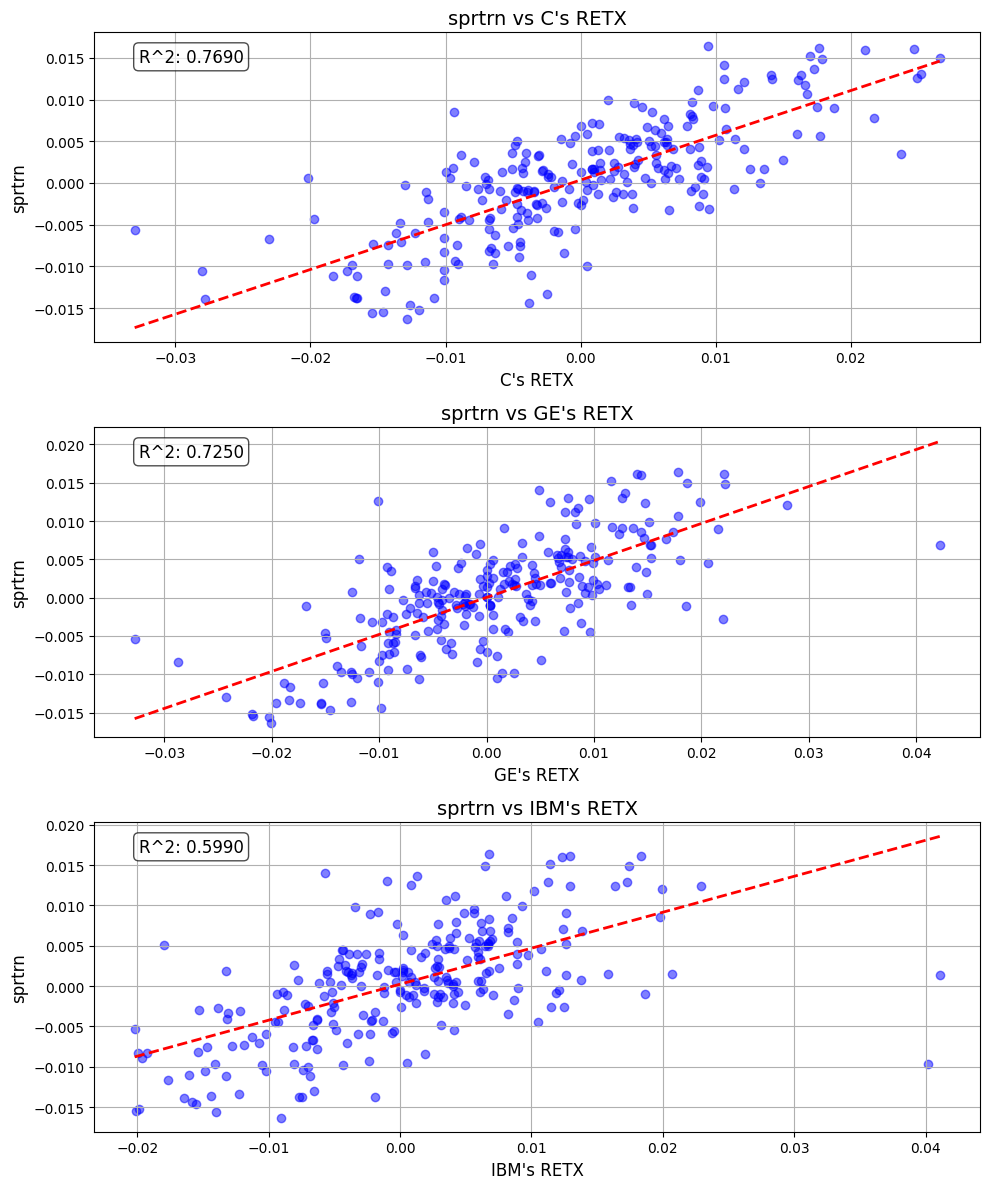

In [37]:
# 设置选择变量，同时令没有标准化的X和y作为数据点
# Set the selected variables, and at the same time, use the non - standardized X and y as data points.
lasso_selected = ['C', 'GE', 'IBM']
X = data[companies]
y = data['sprtrn']

fig, axes = plt.subplots(nrows=len(lasso_selected), ncols=1, figsize=(10, 4*len(lasso_selected)))

for i, var in enumerate(lasso_selected):
    axes[i].scatter(X[var], y, alpha=0.5, color='blue')
    axes[i].set_xlabel(f"{var}'s RETX", fontsize=12)
    axes[i].set_ylabel('sprtrn', fontsize=12)
    axes[i].set_title(f"sprtrn vs {var}'s RETX", fontsize=14)
    
    # 添加回归线，便于比较散点离散程度
    # Add a regression line to facilitate the comparison of the scatter of data points.
    z = np.polyfit(X[var], y, 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(X[var]), max(X[var]), 100)
    axes[i].plot(x_range, p(x_range), "r--", linewidth=2)
    
    # 添加相关系数，用于结果分析
    # Add the correlation coefficient for result analysis.
    corr = np.corrcoef(X[var], y)[0, 1]
    axes[i].text(0.05, 0.95, f'R^2: {corr:.4f}', 
                transform=axes[i].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    axes[i].grid(True)

plt.tight_layout()
plt.show()

1. 随着正则化水平提高，lasso会选择 `C` 和 `GE` 作为主要变量。观察C和GE的RETX和sprtrn散点图可以发现数据点的线性程度较高，离散程度较低，散点普遍聚集在回归线附近。它们的相关系数都在0.7以上也映证了这一点。这说明 `C` 和 `GE` 确实对模型贡献最大、有最强的解释性。  

2. 作为次要变量加入 `IBM` 数据点线性程度显著低于 `C` 和 `GE` ，离散程度也更高，相关系数只有0.6左右。说明IBM作为次要变量对模型的贡献更少、解释性更低。也侧面反映了lasso模型在高正则化水平时选择 `C` 和 `GE` 的正确性。

综上所述，考虑建立更简单而泛化能力更强的模型时，应只保留 `C` 和 `GE` 两个解释性最强的主要变量。而如果允许正则化水平稍低，则可以加入变量 `IBM` 以提高模型预测能力。  

1. As the regularization level increases, Lasso selects `C` and `GE` as the main variables. By observing the scatter plots of RETX and sprtrn for `C` and `GE`, it can be seen that the data points exhibit a high degree of linearity and a low degree of dispersion, with most of the scatter points clustering around the regression line. The fact that their correlation coefficients are above 0.7 also corroborates this. This indicates that `C` and `GE` indeed contribute the most to the model and have the strongest explanatory power.

2. As a secondary variable, the linear degree of `IBM` data points is significantly lower than that of `C` and `GE`, and the degree of dispersion is higher, with a correlation coefficient of only around 0.6. This shows that `IBM`, as a secondary variable, contributes less to the model and has lower explanatory power. It also indirectly reflects the correctness of the Lasso model in selecting `C` and `GE` at a high regularization level.

In conclusion, when considering building a simpler model with stronger generalization ability, only the two main variables `C` and `GE` with the strongest explanatory power should be retained. However, if a slightly lower regularization level is allowed, the variable `IBM` can be added to improve the model's predictive ability.